# Ruiz-Garcia and Miranda (2007)

The aim of this procedure is the estimation of the median spectral acceleration value that brings the structure to the attainment of a set of damage states ds, and the corresponding dispersion. The aim is achieved making use of the work by Ruiz-Garcia and Miranda (2007), where the inelastic displacement demand of bilinear SDoF systems is related to the elastic displacement by means of the inelastic displacement ratio Cr (inelastic over elastic spectral displacement). Estimates of Cr parameter are provided by Ruiz-Garcia and Miranda (2007) in terms of median and dispersion, as result of nonlinear regression analysis of 240 ground motions.

<img src="../../../../../figures/RGM_Cr.jpg" width="400" align="middle">

##Load capacity curves

In order to use this methodology, it is necessary to provide one (or a group) of pushover curves, defined according to the format established on the [RMTK manual](../../../../../rmtk-docs.pdf). The user needs to provide the following information:
- The location of the folder containing the pushover curves using the parameter capacity_curves_file.
- The type of information provided in the input using the parameter input_type. The user can provide either base shear and top displacement or base shear and displacement of each storey.
- A spectral shape in case multiple pushover curves are input.

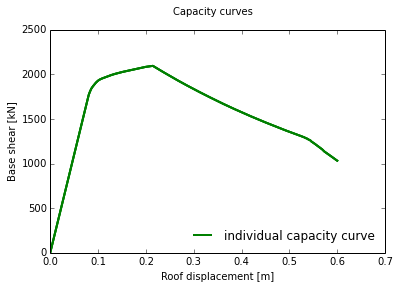

In [1]:
from rmtk.vulnerability.common import utils
%matplotlib inline 

capacity_curves_file = '../../../../../../rmtk_data/capacity_curves_Vb-droof.csv'
input_type = 'Vb-droof'
input_spectrum = '../../../../../../rmtk_data/FEMAP965spectrum.txt'

capacity_curves = utils.read_capacity_curves(capacity_curves_file)
utils.plot_capacity_curves(capacity_curves)
Sa_ratios = utils.get_spectral_ratios(capacity_curves,input_spectrum)

##Idealise pushover curves

In order to use this methodology the pushover curves needs to be idealised. Only bilinear idealised shape can be selected with parameter idealised_type. Idealised curves can be directly provided as input setting the field 'Idealised' to TRUE in the input_file.

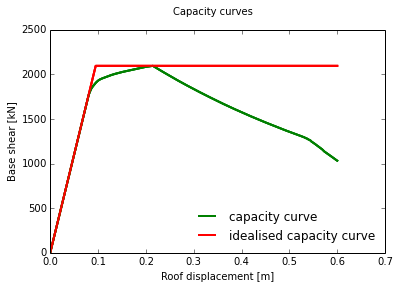

In [2]:
idealised_type = 'bilinear'

idealised_capacity = utils.idealisation(idealised_type, capacity_curves)
utils.plot_idealised_capacity(idealised_capacity, capacity_curves, idealised_type)

##Load damage state thresholds

Please define in the variable damage_state_file the path to your damage model.

In [3]:
damage_model_file = '../../../../../../rmtk_data/damage_model_ISD.csv'
damage_model = utils.read_damage_model(damage_model_file)
print damage_model

{'dispersion': [[0.05, 0.05, 0.05, 0.05]], 'type_criteria': 'interstorey drift', 'distribution': ['normal', 'normal', 'normal', 'normal'], 'median': [[0.005, 0.01, 0.02, 0.05]], 'damage_states': ['Slight', 'Moderate', 'Extensive', 'Collapse']}


##Calculate fragility functions

The record-to-record and the damage threshold dispersions are calculated and integrated making use of monte carlo simulations. Please enter the numebr of monte carlo simulations that want to be performed in the variables montecarlo_samples.

In [4]:
from rmtk.vulnerability.derivation_fragility.R_mu_T_dispersion.ruiz_garcia_miranda import RGM2007 
import scipy.stats as stat
montecarlo_samples = 25

fragility_model = RGM2007.calculate_fragility(capacity_curves, idealised_capacity, damage_model, montecarlo_samples, Sa_ratios)

mu(LS) =  [ 1.62898916  3.25797831  6.30729041  6.30729041]
median IM =  [ 0.18504828  0.36805682  0.70441341  0.70441341]
total dispersion =  [ 0.17691971  0.33231143  0.38763251  0.38763123]
mu(LS) =  [ 1.62898916  3.25797831  6.30729041  6.30729041]
median IM =  [ 0.18504828  0.36805682  0.70441341  0.70441341]
total dispersion =  [ 0.17691971  0.33231143  0.38763251  0.38763123]


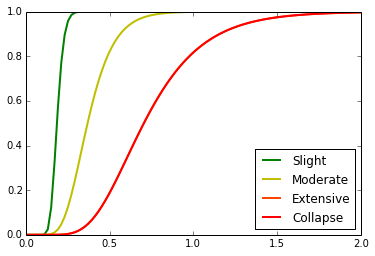

In [5]:
output_type = 'mean-sigma'
#'median-dispersion' #'logmean-cov' #'mean-sigma'
save = 1

utils.plot_fragility_model(fragility_model,0.01,2,save)
utils.create_fragility_out_files(fragility_model,output_type,save)